In [5]:
print('Loading data...')
# Load pickled data
import pickle

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

print('Done loading data')

Loading data...
Done loading data


In [6]:
### To start off let's do a basic data summary.
n_train = len(train_features)
n_test = len(test_features)
image_shape = "{}x{}".format(len(train_features[0]), len(train_features[0][0]))
n_classes = max(train_labels) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32
Number of classes = 43


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

train_features = np.array(train['features'])
train_labels = np.array(train['labels'])

inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()

for i in range(n_classes):
    for j in range(len(train_labels)):
        if (i == train_labels[j]):
            print('Class: ', i)
            plt.imshow(train_features[j])
            plt.show()
            break

print('Data visualisation complete')

Class:  0


Class:  1


Class:  2


Class:  3


Class:  4


Class:  5


Class:  6


Class:  7


Class:  8


Class:  9


Class:  10


Class:  11


Class:  12


Class:  13


Class:  14


Class:  15


Class:  16


Class:  17


Class:  18


Class:  19


Class:  20


Class:  21


Class:  22


Class:  23


Class:  24


Class:  25


Class:  26


Class:  27


Class:  28


Class:  29


Class:  30


Class:  31


Class:  32


Class:  33


Class:  34


Class:  35


Class:  36


Class:  37


Class:  38


Class:  39


Class:  40


Class:  41


Class:  42


Data visualisation complete


In [13]:
print('Preprocessing data...')
# Generate additional data for underrepresented classes
print('Generating additional data...')
angles = [-5, 5, -10, 10, -15, 15, -20, 20]

for i in range(len(inputs_per_class)):
    input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)

    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_features[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    train_features = np.append(train_features, new_features, axis=0)
    train_labels = np.append(train_labels, new_labels, axis=0)

# Normalize features
print('Normalizing features...')
train_features = train_features / 255. * 0.8 + 0.1

# Get randomized datasets for training and validation
print('Randomizing datasets...')
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(
   train_features,
   train_labels,
   test_size=0.2,
   random_state=832289
)

print('Data preprocessed')

Preprocessing data...
Generating additional data...
Normalizing features...
Randomizing datasets...
Data preprocessed


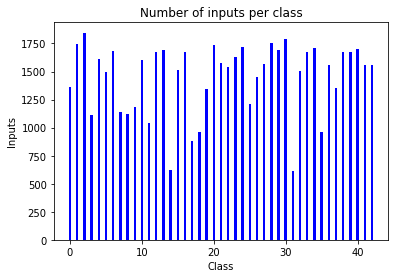

In [14]:
inputs_per_class = np.bincount(train_labels)
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()


In [16]:
print('Creating network architecture...')
import tensorflow as tf
# Input dimensions
image_width = len(train_features[0][0])
image_height = len(train_features[0])
color_channels = len(train_features[0][0][0])

# Convolutional layer patch and output size
filter_width = 3
filter_height = 3
conv_k_output = 128

# Dimension parameters for each fully connected layer
fc_params = [
    image_width * image_height * conv_k_output,
    1024,
    1024,
    n_classes
]

# Build weights and biases
conv2d_weight = None
conv2d_bias = None
fc_weights = []
fc_biases = []

with tf.variable_scope('BONHOMME', reuse=False):
    conv2d_weight = tf.get_variable("conv2w", shape=[filter_width, filter_height, color_channels, conv_k_output], initializer=tf.contrib.layers.xavier_initializer())
    conv2d_bias = tf.get_variable("conv2b", shape=[conv_k_output], initializer=tf.contrib.layers.xavier_initializer())
    
    for i in range(len(fc_params) - 1):
        fc_weights.append(tf.get_variable('fc_weight' + str(i), shape=[fc_params[i], fc_params[i + 1]], initializer=tf.contrib.layers.xavier_initializer()))
        fc_biases.append(tf.get_variable('fc_bias' + str(i), shape=[fc_params[i + 1]], initializer=tf.contrib.layers.xavier_initializer()))

# One-hot encoded training and validation labels
oh_train_labels = tf.one_hot(train_labels, n_classes).eval(session=tf.Session())
oh_valid_labels = tf.one_hot(valid_labels, n_classes).eval(session=tf.Session())

# Input placeholders
input_ph = tf.placeholder(tf.float32, shape=[None, image_width, image_height, color_channels])
labels_ph = tf.placeholder(tf.float32)

# Convolutional layer
network = tf.nn.conv2d(input_ph, conv2d_weight, strides=[1, 1, 1, 1], padding='SAME')
network = tf.nn.bias_add(network, conv2d_bias)
network = tf.nn.relu(network)

# Fully connected layers
for i in range(len(fc_weights)):
    network = tf.matmul(tf.contrib.layers.flatten(network), fc_weights[i]) + fc_biases[i]
    if i < len(fc_weights) - 1: # No relu after last FC layer
        network = tf.nn.relu(network)

# Loss computation
prediction = tf.nn.softmax(network)
cross_entropy = -tf.reduce_sum(labels_ph * tf.log(prediction + 1e-6), reduction_indices=1)
loss = tf.reduce_mean(cross_entropy)

# Accuracy computation
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels_ph, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Network architecture created')

Creating network architecture...
Network architecture created


In [17]:
test_features = np.array(test_features) / 255 * 0.8 + 0.1
oh_test_labels = tf.one_hot(test_labels, n_classes).eval(session=tf.Session())
print('Test label one hot encoded')

Test label one hot encoded


In [18]:
batch_size = 150

def run_batch(session, network, features, labels):
    batch_count = int(len(features) / batch_size)
    accuracy = 0
    
    for i in range(batch_count):
        batch_start = i * batch_size
        accuracy += session.run(
            network,
            feed_dict={
                input_ph: features[batch_start:batch_start + batch_size],
                labels_ph: labels[batch_start:batch_start + batch_size]
            }
        )
    
    return accuracy / batch_count

print('Run batch function created')

Run batch function created


Epoch  3/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 416/416 [42:16<00:00,  6.10s/batches]


Final validation accuracy:  0.9628205087322456
Final test accuracy:  0.8236507922410965


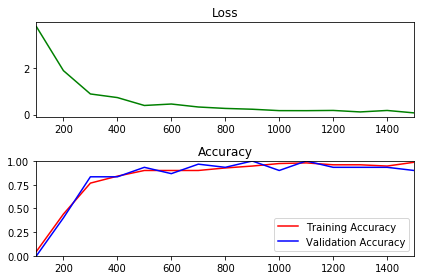

In [19]:
from tqdm import tqdm

training_epochs = 3
optimizer = tf.train.AdamOptimizer().minimize(loss)

log_batch_step = 100
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []
validation_accuracy = 0.0

init = tf.global_variables_initializer()

session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(init)
batch_count = int(len(train_features) / batch_size)

for epoch in range(training_epochs):
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, training_epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        batch_start = batch_i * batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = oh_train_labels[batch_start:batch_start + batch_size]

        _, l = session.run(
            [optimizer, loss],
            feed_dict={input_ph: batch_features, labels_ph: batch_labels})

        if not batch_i % log_batch_step:
            training_accuracy = session.run(
                accuracy,
                feed_dict={input_ph: batch_features, labels_ph: batch_labels}
            )

            idx = np.random.randint(len(valid_features), size=int(batch_size * .2))

            validation_accuracy = session.run(
                accuracy,
                feed_dict={input_ph: valid_features[idx,:], labels_ph: oh_valid_labels[idx,:]}
            )

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)


validation_accuracy = run_batch(session, accuracy, valid_features, oh_valid_labels)    
test_accuracy = run_batch(session, accuracy, test_features, oh_test_labels)

print('Final validation accuracy: ', validation_accuracy)
print('Final test accuracy: ', test_accuracy)
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

Instructions for updating:
Use the `axis` argument instead
Accuracy on Test-Set: 82.4% (10401 / 12630)
Confusion Matrix:


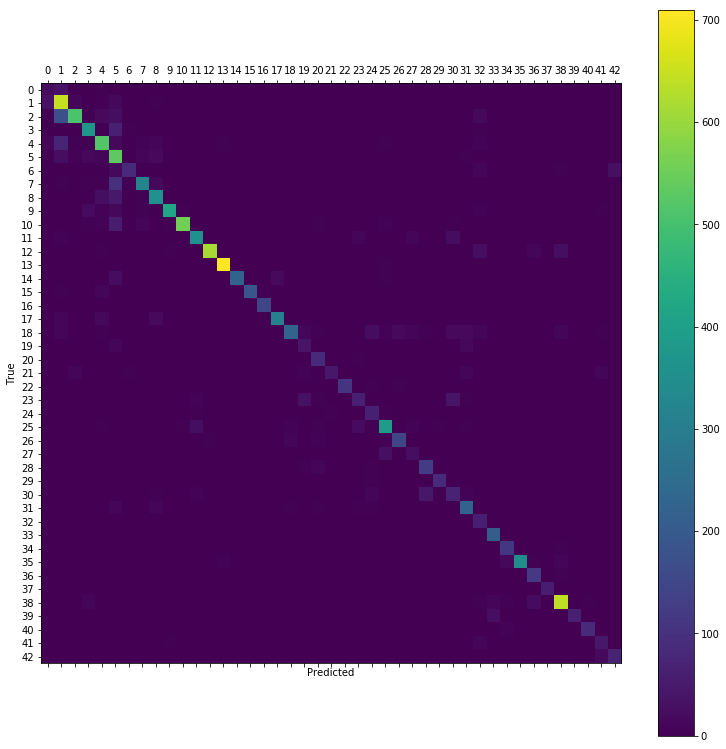

In [20]:
test_batch_size = 250
y_pred_cls = tf.argmax(prediction, dimension=1)
test_cls = np.argmax(oh_test_labels, axis=1)
from pylab import rcParams
from sklearn.metrics import confusion_matrix

img_shape = (32, 32, 3)
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(np.argmax(cls_true[i]))
        else:
            xlabel = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), np.argmax(cls_pred[i]))
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=test_cls,
                          y_pred=cls_pred)

    plt.figure(figsize=(40,40))
    rcParams['figure.figsize'] = 13, 13
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

def plot_example_errors(cls_pred, correct):

    incorrect = (correct == False)    
    images = test_features[incorrect]    
    cls_pred = cls_pred[incorrect]
    cls_true = test_cls[incorrect]    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(test_features)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        batch_features = test_features[i:j]
        batch_labels = oh_test_labels[i:j]
        
        feed_dict={input_ph: batch_features, labels_ph: batch_labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    correct = (test_cls == cls_pred)
    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

print_test_accuracy(show_example_errors=False, show_confusion_matrix=True)

In [2]:
import matplotlib.image as mpimg

imgs = ['20.png', '80.png', 'exclamation.png', 'hochwasser.png', 'priority.png']

new_input = []

for imgname in imgs:
    image = mpimg.imread('images/' + imgname)
    new_input.append(image)
    plt.imshow(image)
    plt.show()

NameError: name 'plt' is not defined

In [29]:
new_predictions = session.run(prediction, feed_dict={input_ph: new_input})

In [28]:
print(new_predictions)

[[1.13001689e-02 1.67708332e-03 2.88844202e-03 2.73870602e-02
  1.32138368e-07 4.56652828e-02 8.47165339e-15 6.05200834e-10
  2.05455159e-04 4.51124564e-04 7.23424820e-10 2.55657908e-12
  3.04366921e-10 8.99994671e-01 5.53629889e-07 8.72043771e-08
  4.35022331e-12 8.37463085e-06 3.88259416e-08 1.87617205e-15
  1.56241913e-05 9.63718793e-20 3.30159615e-11 5.85833292e-12
  9.09234771e-11 3.50029033e-04 7.07327992e-16 7.18531845e-18
  1.00456635e-02 8.24404742e-06 1.13133363e-15 1.54207105e-10
  1.71412641e-11 1.28042360e-24 2.26595413e-12 6.05572060e-12
  2.89732932e-10 3.01320405e-22 1.91412687e-06 3.67694909e-26
  7.00178981e-16 3.24187316e-10 2.36592846e-16]
 [1.82464941e-08 6.80958200e-03 1.69107909e-04 1.26724718e-02
  9.49375534e-15 9.80348885e-01 2.48925271e-19 2.14970768e-16
  2.15766039e-16 7.50038079e-17 5.22529702e-16 4.64989322e-21
  4.74805133e-27 5.48828010e-15 1.75605765e-19 2.02448582e-15
  1.42877508e-28 2.40466047e-14 5.39789069e-25 2.81780981e-27
  9.67970354e-24 7.072

In [3]:
print(session.run(tf.nn.top_k(prediction, 2), feed_dict={input_ph: new_input}))


NameError: name 'session' is not defined